# Optimal control pulses to prepare states in an oscillator dispersively coupled to a transmon


## Imports

In [98]:
import optax
import numpy             as np
import diffrax           as dx
import jax.numpy         as jnp
import jax.tree_util     as jtu
import matplotlib.pyplot as plt

from jax       import Array
from functools import partial
from dynamiqs  import basis, dag, destroy, sesolve, timecallable, eye, tensor, fock
from optamiqs  import GRAPEOptions, all_cardinal_states, generate_file_path, grape, PulseOptimizer
from optamiqs  import IncoherentInfidelity, ForbiddenStates

In [104]:
# Hamiltonian params in GHz
anharmonicity = -250e-3 
chi           = -350e-6
chi_prime     = 0e6

# Construct the Hamiltonian
c_dim     = 5
q_dim     = 3
a         = tensor( destroy(c_dim), eye(q_dim) )
q         = tensor( eye(c_dim), destroy(q_dim) )
num_a     = dag(a) @ a
num_q     = dag(q) @ q

# Transmon anharmonicity
H0        = 0.5 * anharmonicity * dag(a) @ dag(a) @ a @ a
# Cavity-tranmson cross-Kerr
H0       += chi * dag(a) @ a @ dag(q) @ q
# 6-th order cross-Kerr correction
H0       += chi_prime * dag(a) @ dag(a) @ a @ a @ dag(q) @ q
H0       *= 2.0 * jnp.pi

# Define the controls
H_ctrls   = [a + dag(a), 1j * (a - dag(a)), q + dag(q), 1j * (q - dag(q))]
H1_labels = ['cI', 'cQ', 'qI', 'qQ']



In [108]:
# Set initial, target and forbidden states
initial_states    = [fock((c_dim, q_dim), (0, 0))]
final_states      = [fock((c_dim, q_dim), (1, 0))]
_forbidden_states = [fock((c_dim, q_dim), (2, 0)), fock((c_dim, q_dim), (0, 2))]

forbidden_states  = len(initial_states) * _forbidden_states

In [109]:
# Define the pulse params
pulse_time = 5000 # ns
dt         = 4   # ns
ramp_nts   = 100  # numper of points in ramps

ntimes     = int(pulse_time // dt) + 1
tsave      = jnp.linspace(0, pulse_time, ntimes)

# Define an envelope 
# Here we define a cosine ramp and force the control endpoints to be at zero 
cos_ramp   = (1 - jnp.cos(jnp.linspace(0.0, jnp.pi, ramp_nts))) / 2
envelope   = jnp.concatenate((cos_ramp, jnp.ones(ntimes - 2 * ramp_nts), jnp.flip(cos_ramp)))

In [110]:
# Define optimizer and set options
TARGET_FID  = 0.99
EPOCHS      = 100
SAVE_STATES = True

optimizer   = optax.adam(learning_rate=0.0001, b1=0.999, b2=0.999)
options     = GRAPEOptions( save_states     = SAVE_STATES,
                            progress_meter  = None,
                            target_fidelity = TARGET_FID,
                            epochs          = EPOCHS,
                            )

# need to form superpositions so that the phase information is correct
if not options.coherent:
    initial_states = all_cardinal_states(initial_states)
    final_states   = all_cardinal_states(final_states)

# Define the cost function
costs = [
    IncoherentInfidelity(target_states=final_states, cost_multiplier=1.0),
    ForbiddenStates(forbidden_states=forbidden_states, cost_multiplier=5.0),
]

In [111]:
# Define initial seed pulse
init_drive_params = 0.001 * jnp.ones((len(H_ctrls), ntimes))

In [112]:
def _drive_spline(drive_params: Array, envelope: Array, ts: Array ) -> dx.CubicInterpolation:
    
    # Apply the envelope to the pulse
    # note swap of axes so that time axis is first
    drive_w_envelope = jnp.einsum('t,dt->td', envelope, drive_params)
    # Does cubic interpolation and calculates the coefficients
    drive_coeffs     = dx.backward_hermite_coefficients(ts, drive_w_envelope)
    # Uses the coefficients to create a cubic interpolation function
    return dx.CubicInterpolation(ts, drive_coeffs)

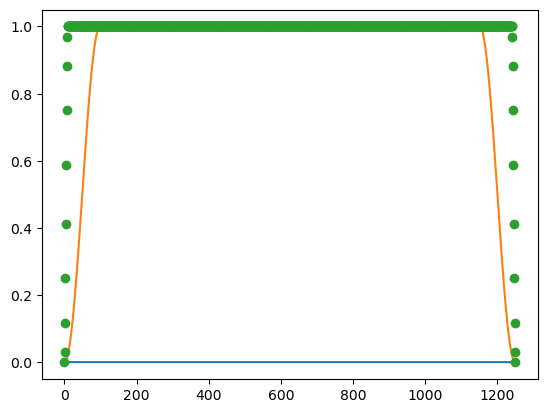

In [113]:
plt.plot(np.arange(ntimes), init_drive_params[0])
plt.plot(np.arange(ntimes), envelope)
plt.plot(np.arange(ntimes), rr, 'o')
plt.show()

In [114]:
def H_func(t: float, drive_params: Array, envelope: Array, ts: Array) -> Array:
    drive_spline = _drive_spline(drive_params, envelope, ts)
    drive_amps   = drive_spline.evaluate(t)
    drive_Hs     = jnp.einsum('d,dij->ij', drive_amps, H_ctrls)
    return H0 + drive_Hs

def update_func(H, drive_params):
    H_f = jtu.Partial(H, drive_params=drive_params)
    return timecallable(H_f)

In [115]:
H_tc            = jtu.Partial(H_func, envelope=envelope, ts=tsave)
pulse_optimizer = PulseOptimizer(H_tc, update_func)

In [116]:
filename   = generate_file_path('h5py', 'Kerr_tc', 'out')

opt_params = grape( pulse_optimizer,
                    initial_states     = initial_states,
                    tsave              = tsave,
                    costs              = costs,
                    params_to_optimize = init_drive_params,
                    filepath           = filename,
                    optimizer          = optimizer,
                    options            = options,
                    )

saving results to out\00002_Kerr_tc.h5py


c:\Users\Akshay\anaconda3\envs\opt-dynamiqs\lib\site-packages\jax\_src\lax\lax.py:2803: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


epoch: 0, fids: [0.0499447], elapsed_time: 91.309 s
epoch: 1, fids: [0.34821773], elapsed_time: 84.397 s
epoch: 2, fids: [0.576978], elapsed_time: 84.293 s
epoch: 3, fids: [0.7596019], elapsed_time: 84.405 s
epoch: 4, fids: [0.89432377], elapsed_time: 84.158 s
epoch: 5, fids: [0.9129848], elapsed_time: 84.166 s
epoch: 6, fids: [0.9305095], elapsed_time: 84.18 s
epoch: 7, fids: [0.96338546], elapsed_time: 84.503 s
epoch: 8, fids: [0.9788588], elapsed_time: 84.41 s
epoch: 9, fids: [0.97681445], elapsed_time: 84.386 s
epoch: 10, fids: [0.9670962], elapsed_time: 84.394 s
epoch: 11, fids: [0.95999086], elapsed_time: 84.635 s
epoch: 12, fids: [0.9627626], elapsed_time: 84.453 s
epoch: 13, fids: [0.97397155], elapsed_time: 84.03 s
epoch: 14, fids: [0.98887694], elapsed_time: 84.094 s
epoch: 15, fids: [0.995911], elapsed_time: 84.366 s
target fidelity reached
reached maximum number of allowed epochs
all results saved to out\00002_Kerr_tc.h5py


In [117]:
finer_times  = jnp.linspace(0.0, pulse_time, 201)
drive_spline = _drive_spline(opt_params, envelope, tsave)
drive_amps   = jnp.asarray(
                            [drive_spline.evaluate(t) for t in finer_times]
                            ).swapaxes(0, 1)

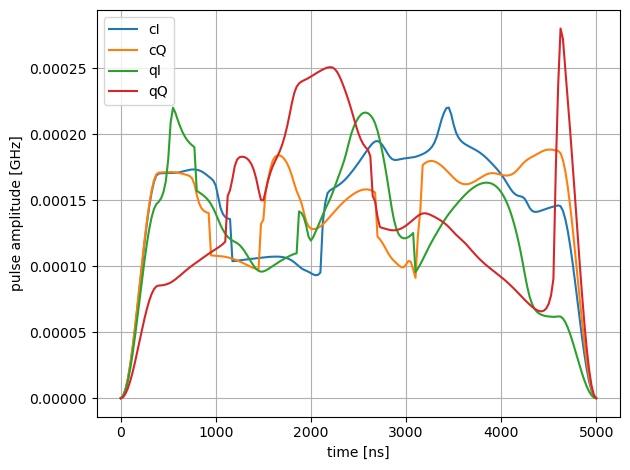

In [118]:
fig, ax = plt.subplots()
for drive_idx in range(len(H_ctrls)):
    plt.plot(finer_times, drive_amps[drive_idx] / (2.0 * np.pi), label=H1_labels[drive_idx],)

ax.set_xlabel('time [ns]')
ax.set_ylabel('pulse amplitude [GHz]')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [119]:
H_f  = partial(H_func, drive_params=opt_params, envelope=envelope, ts=tsave)
H_tc = timecallable(H_f)

In [120]:
plot_result = sesolve(
    H_tc,
    initial_states,
    finer_times,
    exp_ops=[num_a, num_q],
    options=options,
)

In [121]:
init_labels = [
        r'$|0\rangle$',
        r'$|0\rangle+|1\rangle$',
        r'$|0\rangle+i|1\rangle$',
        r'$|1\rangle$',
    ]
exp_labels = [r'$|0\rangle$', r'$|1\rangle$', r'$|2\rangle$', r'$|3\rangle$']

c:\Users\Akshay\anaconda3\envs\opt-dynamiqs\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


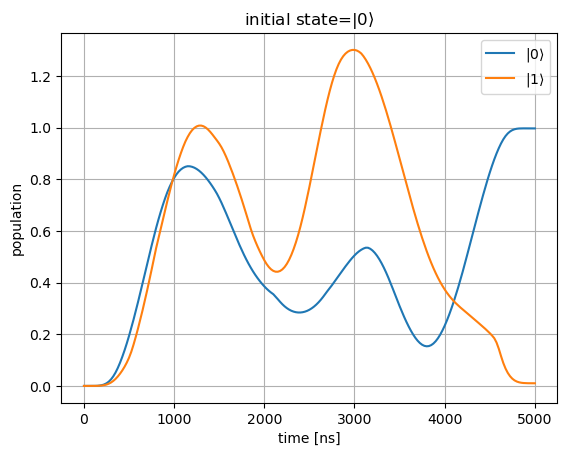

In [123]:
# for brevity only plot one initial state
state_idx_to_plot = 0
fig, ax = plt.subplots()
expects = plot_result.expects[state_idx_to_plot]
for e_result, label in zip(expects, exp_labels):
    plt.plot(finer_times, e_result, label=label)
ax.legend()
ax.set_xlabel('time [ns]')
ax.set_ylabel('population')
ax.set_title(f'initial state={init_labels[state_idx_to_plot]}')
ax.grid()
plt.show()